# HRM Mechanistic Analysis Demo

We strongly recommend that one complete the steps in `README.md` before trying to run this demo. You can just read the results, which are equally informative, though.

After walking through this demo, one should be able to understand how to extract and visualize intermediate reasoning trajectories with our utilities. 

We start by loading a trained checkpoint. We provide a trained one for convenience, but you are free to train your own (see the README file).

In [ ]:
import numpy as np
import torch
from eval_utils import load_checkpoint_and_config, create_single_sample, forward_single_sample
from pretrain import create_dataloader, init_train_state

# Provided is a final checkpoint trained under vanilla HRM setting, which produces results in the paper.
# Replace this with the path to your checkpoint; should be something like this:
checkpoint_path = "checkpoint_example/Sudoku-extreme-1k-aug-1000 ACT-torch/HierarchicalReasoningModel_ACTV1 pastel-lorikeet/example_checkpoint"
checkpoint_file, config, checkpoint_dir = load_checkpoint_and_config(checkpoint_path) # This works for maze checkpoints as well!

torch.random.manual_seed(config.seed)

# Create a dummy dataloader to get metadata (adapted from eval_checkpoint.py)
# We need this to get vocab_size, seq_len, etc.
_, train_metadata = create_dataloader(
    config, "train",
    test_set_mode=False,
    epochs_per_iter=1,
    global_batch_size=1,  # Small batch for metadata only
    rank=0,
    world_size=1
)

train_state = init_train_state(config, train_metadata, world_size=1)

# Load checkpoint weights (adapted from eval_checkpoint.py)
print(f"Loading checkpoint: {checkpoint_file}")
checkpoint = torch.load(checkpoint_file, map_location="cuda")
try:
    train_state.model.load_state_dict(checkpoint, assign=True)
except:
    # Handle torch.compile wrapped models
    cleaned_state_dict = {k.removeprefix("_orig_mod."): v for k, v in checkpoint.items()}
    train_state.model.load_state_dict(cleaned_state_dict, assign=True)

Loaded config from: checkpoint_example/Sudoku-extreme-1k-aug-1000 ACT-torch/HierarchicalReasoningModel_ACTV1 pastel-lorikeet/all_config.yaml
Model: hrm.hrm_act_v1@HierarchicalReasoningModel_ACTV1
Data path: data/sudoku-extreme-1k-aug-1000
Loading checkpoint: checkpoint_example/Sudoku-extreme-1k-aug-1000 ACT-torch/HierarchicalReasoningModel_ACTV1 pastel-lorikeet/example_checkpoint


## Creating Inputs

The puzzles are created as numpy arrays. We use one from the test set of Sudoku-Extreme (you should have built the dataset yourself). You may create other puzzles by hand (for example, the easier puzzles mentioned in the paper), of course.

Also try loading a checkpoint for Maze-30x30-hard dataset and visualize the reasoning trajectory!

In [2]:
train_state.model.eval()

idx = 8 # This is the sample generating figures in the paper. Try out other ones!
all_inputs = np.load("data/sudoku-extreme-1k-aug-1000/test/all__inputs.npy")
all_labels = np.load("data/sudoku-extreme-1k-aug-1000/test/all__labels.npy")
inputs = all_inputs[idx]
labels = all_labels[idx]

batch = create_single_sample(inputs, labels)

print(batch["inputs"].view(9,9))
print(batch["labels"].view(9,9)) # Note that tokens are 2~10 while 1 represents blank.

tensor([[ 6,  4,  1,  7,  1,  5,  1,  1,  1],
        [ 1,  1,  5,  1,  1,  3,  1,  1,  1],
        [ 1,  9,  1,  1,  2,  1,  1,  8,  1],
        [ 7,  1,  1,  1,  5,  1,  1,  1,  1],
        [ 9,  1,  3,  4,  1,  6,  1,  1,  7],
        [ 1,  1,  1,  1,  1,  1,  8,  1, 10],
        [ 1,  1,  1,  1,  1,  1,  1,  7,  1],
        [ 1,  7,  2,  8,  6,  1,  1,  5,  1],
        [ 1,  1,  4,  1,  1,  1,  1,  1,  2]])
tensor([[ 6,  4,  8,  7,  9,  5,  2, 10,  3],
        [ 2, 10,  5,  6,  8,  3,  7,  4,  9],
        [ 3,  9,  7, 10,  2,  4,  6,  8,  5],
        [ 7,  2, 10,  9,  5,  8,  4,  3,  6],
        [ 9,  8,  3,  4, 10,  6,  5,  2,  7],
        [ 4,  5,  6,  2,  3,  7,  8,  9, 10],
        [ 5,  6,  9,  3,  4,  2, 10,  7,  8],
        [10,  7,  2,  8,  6,  9,  3,  5,  4],
        [ 8,  3,  4,  5,  7, 10,  9,  6,  2]])


## Forwarding Single Sample

Single sample inference is fully supported with most information stored in the `result` dictionary. See `eval_utils.py` for details.

In [3]:
print("========== Starting Inference ==========")
results = forward_single_sample(
    model=train_state.model,
    batch=batch
)

print("========== Inference Results ==========")
for step, preds in enumerate(results["all_predictions"]):
    pred_seq = preds.numpy()[0]
    loss = results["all_losses"][step]
    print(f"Step {step+1}, Loss {loss}")
    print(pred_seq.reshape(9, 9)-1)

========== Starting Inference ==========
========== Inference Results ==========
Step 1, Loss 0.5322204535658461
[[5 3 9 6 7 4 1 9 2]
 [1 1 4 8 3 2 6 9 5]
 [2 8 6 5 1 3 3 7 4]
 [6 9 9 1 4 7 8 3 5]
 [8 7 2 3 9 5 4 1 6]
 [3 4 5 1 6 6 7 8 9]
 [4 5 8 1 3 1 5 6 7]
 [9 6 1 7 5 8 3 4 3]
 [7 5 3 4 6 6 5 5 1]]
Step 2, Loss 0.4892300171306676
[[5 3 7 6 8 4 1 9 2]
 [1 9 4 5 7 2 6 3 8]
 [2 8 6 5 1 3 3 7 4]
 [6 1 9 2 4 7 8 5 5]
 [8 7 2 3 9 5 4 1 6]
 [3 4 5 8 6 1 7 2 9]
 [4 2 8 1 3 1 5 6 7]
 [9 6 1 7 5 8 2 4 3]
 [7 5 3 4 2 6 9 8 1]]
Step 3, Loss 0.44445955307993645
[[5 3 7 6 8 4 1 9 2]
 [1 7 4 5 3 2 6 3 8]
 [2 8 6 5 1 3 5 7 4]
 [6 1 9 2 4 7 3 5 5]
 [8 7 2 3 9 5 4 1 6]
 [3 4 5 8 6 1 7 2 9]
 [4 5 8 1 3 1 5 6 7]
 [9 6 1 7 5 8 2 4 3]
 [7 5 3 4 2 6 9 8 1]]
Step 4, Loss 0.517038675038064
[[5 3 9 6 7 4 1 9 2]
 [1 7 4 9 3 2 6 3 5]
 [2 8 6 5 1 3 3 7 4]
 [6 1 7 2 4 7 3 5 5]
 [8 9 2 3 9 5 4 1 6]
 [3 4 5 8 6 1 7 2 9]
 [4 2 8 1 3 1 5 6 7]
 [9 6 1 7 5 8 2 4 3]
 [7 5 3 4 2 6 9 5 1]]
Step 5, Loss 0.5041774660766403

## Trajectory Visualization via PCA

We added a `require_trace` option to the forwarding process, which stores intermediate z_H states too. It gives a finer trajectory than the segment-wise version.

The results below show the reasoning trajectory and the attractors.

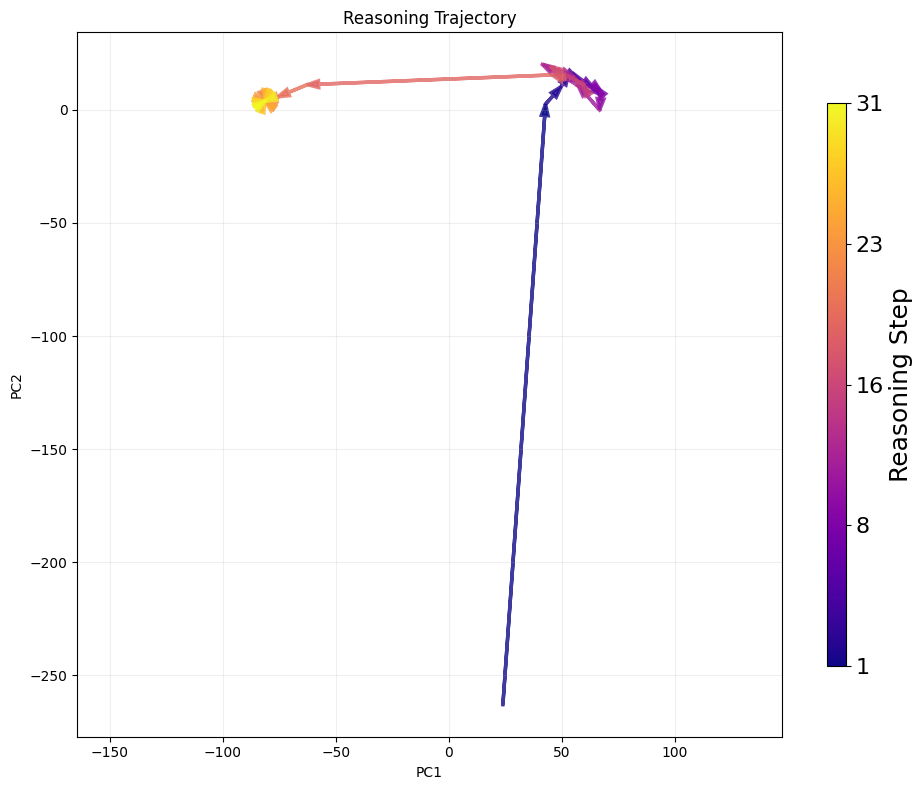

In [4]:
import matplotlib.pyplot as plt
from visualization.pca_trajectory import plot_trajectory
plot_trajectory(results["z_H_traces"])
# plot_trajectory(results["z_H_segments"]) # the segment-wise version, omitting intermidiate z_H with no gradients
plt.show()
plt.close()

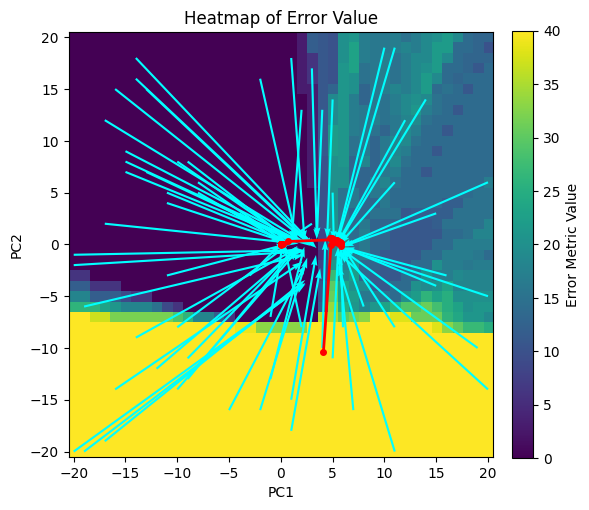

In [5]:
from visualization.landscape import plot_landscape_heatmap, plot_landscape_3d, differentiable_conflict_loss, forward_z
from sklearn.decomposition import PCA

def fit_pca(trajectory):
    flats = []
    for z_H in trajectory:
        flats.append(z_H.flatten().cpu().float().numpy())
    flat_mat = np.stack(flats)
    pca = PCA(n_components=2)
    pca.fit(flat_mat)
    return pca

z_H_trace = results["z_H_traces"]
pca = fit_pca(z_H_trace)
center_carry = results["all_carries"][15]
z_H_center = center_carry.inner_carry.z_H.clone()

e_value = {}
threshold = 40 # Clip at a threshold so that irrelevant large values does not hide the interesting features
dest = {}
scale = ((82*512)**0.5)/8 # Careful when altering this value

for i in range(-20, 21): 
    for j in range(-20, 21):
# For your own sample, you might need to change this range, together with the threshold value, to make the plot more readable.
        d1 = torch.from_numpy(pca.components_[0]*scale).view(1, 82, 512).to("cuda")
        d2 = torch.from_numpy(pca.components_[1]*scale).view(1, 82, 512).to("cuda")
        perturb = i * d1 + j * d2

        # Forward the example one step
        batch = {k: v.cuda() for k, v in batch.items()}
        new_current_data = {k: torch.where(center_carry.halted.view((-1, ) + (1, ) * (batch[k].ndim - 1)), batch[k], v) for k, v in center_carry.current_data.items()}

        starting_carry = center_carry.inner_carry
        starting_z_H = (z_H_center + perturb).bfloat16()
        starting_carry.z_H = starting_z_H

        logits = forward_z(train_state.model, starting_z_H.squeeze(0))
        preds = torch.argmax(logits, dim=-1).view(9, 9)-1
        e = differentiable_conflict_loss(preds)
        e_value[(i, j)] = e if e < threshold else threshold
        
        new_inner_carry, logits, (q_halt_logits, q_continue_logits) = train_state.model.model.inner(starting_carry, new_current_data)
        final_z = new_inner_carry.z_H

        dest[(i, j)] = (pca.transform(final_z.view(1, -1).float().cpu())-pca.transform(z_H_center.view(1, -1).float().cpu()))[0]/scale

plot_landscape_heatmap(e_value, [(pca.transform(z.view(1, -1).float().cpu())-pca.transform(z_H_center.view(1, -1).float().cpu()))[0]/scale for z in z_H_trace], dest)
plt.show()

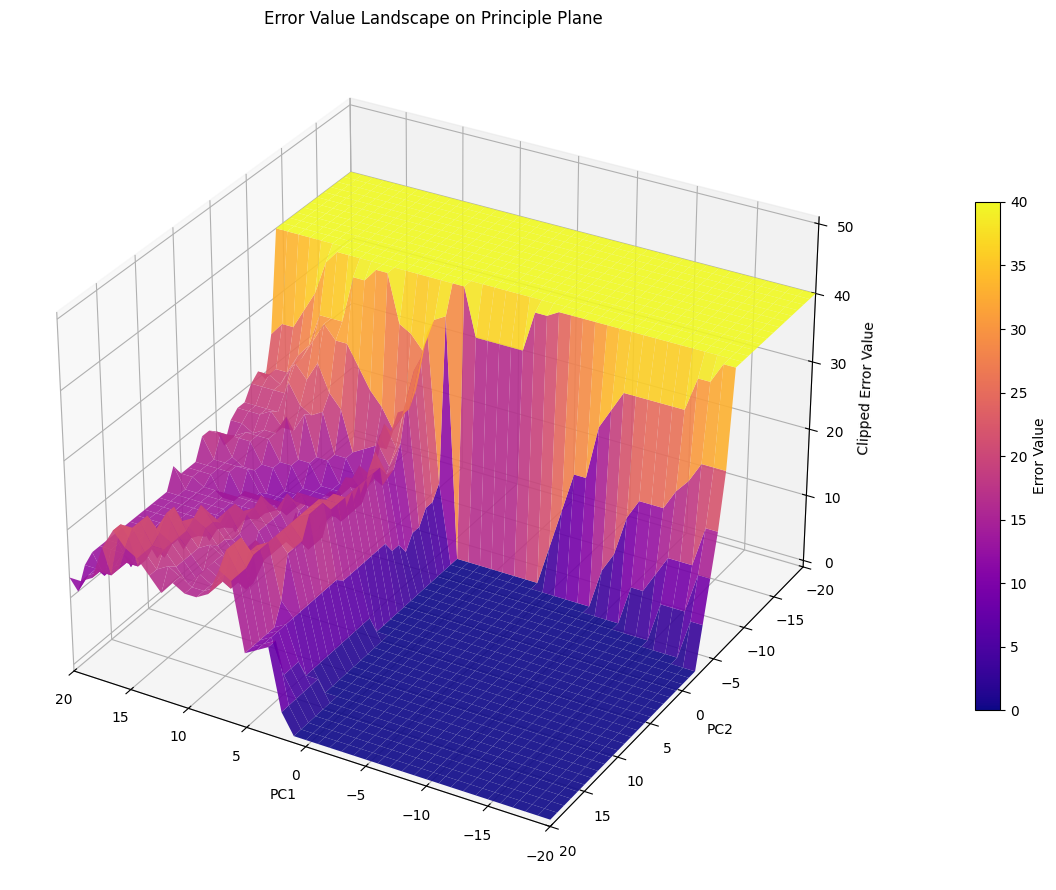

In [6]:
plot_landscape_3d(e_value, 30., 120)

To test HRM and the various augmentation methods we developed, see the **Model Evaluation** part in README.